In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from tensorboardX import SummaryWriter

import numpy as np

from tqdm import tqdm
from tqdm import trange

# import math



device = "cuda" if torch.cuda.is_available() else "cpu"

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
        
        
def output_final(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_loss_inf = 0, 0


    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

#                     test_loss += loss_sup(pred, y).item()
            test_loss += loss_fn(pred, y).item()
            test_loss_inf += torch.linalg.vector_norm(pred-y, ord = float('inf')).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#             correct += (pred == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_loss_inf /= num_batches
#     correct /= size


    return test_loss, test_loss_inf


In [2]:
num_sample = 2000
num_train = int(num_sample*0.8)
num_test = int(num_sample*0.2)

adjust_scale = 0

loss_fn = nn.MSELoss()

width_vector = [10, 20, 40, 80, 160, 320]
# width_vector = [40, 80, 160, 320, 640, 1280]

width_vector_2 = [10, 20, 40, 80, 160, 320]

# width_vector = [80, 160, 320, 640, 1280, 2560]

# para_vector = [4, 8, 16, 32]

# width = 640

times_w = 2

times_n = 1

k_period = 5

batch_size = 8

merge = 0

result_matrix = np.zeros((len(width_vector), 10))
result_matrix_infty = np.zeros((len(width_vector), 10))

result_matrix_adj = np.zeros((len(width_vector_2), 10))
result_matrix_infty_adj = np.zeros((len(width_vector_2), 10))

In [3]:
#generate test set
setup_seed(2022)
Coe = torch.rand(4)
print(Coe)

temp = torch.linspace(-1, 1, num_test)

# for consistency of tensor sizes
x_test = torch.unsqueeze(temp,1)

# # certain function expression: y = sin(\pi x)
y_test = - torch.sin(2 * torch.pi * x_test)
# y_test = Coe[0] + Coe[1] * torch.sin(torch.pi * x_test) + Coe[2] * torch.cos(2 * torch.pi * x_test) + Coe[3] * torch.sin(3 * torch.pi * x_test)
    

# x_test = torch.cat([X_1, X_2], dim=1)
# y_test = torch.unsqueeze(- torch.sin(torch.pi * x_test[:, 0] + torch.pi * x_test[:, 1]), 1)

# create data loaders.
test_set = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_set, batch_size = num_test, shuffle=False)

class NN(nn.Module):
    def __init__(self, layers):
        # First initial the __init__ in nn.Module 
        super(NN, self).__init__()

        self.layer1 = nn.Linear(in_features=layers[0], out_features=layers[1])
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(in_features=layers[1], out_features=layers[2], bias=False)
        self.layer3 = nn.Linear(in_features=layers[2], out_features=layers[3], bias=True)
#         self.layer3 = nn.Linear(in_features=layers[2], out_features=layers[3], bias=False)
#         self.layer2 = nn.Linear(in_features=layers[1], out_features=layers[2])



    def forward(self, x):
#         x = self.flatten(x)
        unacti = self.layer1(x)
        hidden1 = self.relu(unacti)
        hidden2 = self.layer2(hidden1)
        logits = self.layer3(hidden2)

        return logits

tensor([0.3958, 0.9219, 0.7588, 0.3811])


In [4]:
i = 0

# for times_n in tqdm(para_vector):
for width in tqdm(width_vector):
    
    actual_width = times_w*width

        
    for j in range(10):
        
#         print(i,j)
        
        model = NN([1, actual_width, 1, 1]).to(device)
        
        
#         adjust_scale = 0

#         model.load_state_dict(torch.load('Sin-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))
# #         model.load_state_dict(torch.load('Sin-'+str(times_n)+'Xweight-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))
        
#         [result_matrix[i, j], result_matrix_infty[i, j]] = output_final(test_dataloader, model, loss_fn)
        
        
        adjust_scale = 10
        
        model.load_state_dict(torch.load('Sin-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))
#         model.load_state_dict(torch.load('Sin-'+str(times_n)+'Xweight-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))

        [result_matrix_adj[i, j], result_matrix_infty_adj[i, j]] = output_final(test_dataloader, model, loss_fn)
        
        
    i += 1    
        
  

100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


In [14]:
# for function plotting
width = 40
j = 3
adjust_scale = 0

model = NN([1, width*2, 1, 1]).to(device)


model.load_state_dict(torch.load('Sin-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))
        
with torch.no_grad():
    
    X_test = x_test.to(device)
    Y_pred = model(X_test)

    y_pred = Y_pred.cpu().detach().numpy()

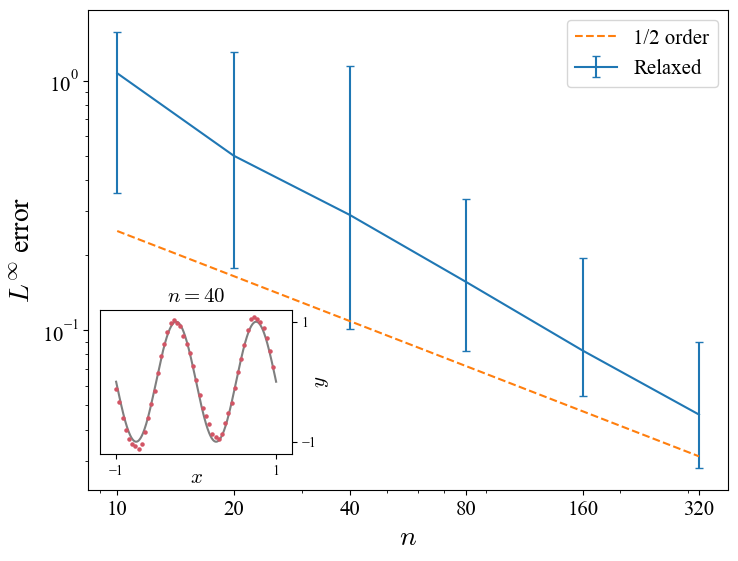

In [17]:
from statistics import geometric_mean

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'

x = width_vector


# mean = np.zeros(int(len(x)))
# mean_infty = np.zeros(int(len(x)))


# for i in range(len(x)):
#     mean[i] = geometric_mean(result_matrix[i])
#     mean_infty[i] = geometric_mean(result_matrix_infty[i])


# y_max = np.max(result_matrix, axis = 1)
# y_min = np.min(result_matrix, axis = 1)

# # yerr = np.vstack((y_min, y_max))
# yerr = np.abs(np.vstack((y_min, y_max)) - mean)


# y_max_infty = np.max(result_matrix_infty, axis = 1)
# y_min_infty = np.min(result_matrix_infty, axis = 1)

# # yerr_infty = np.vstack((y_min_infty, y_max_infty))
# yerr_infty = np.abs(np.vstack((y_min_infty, y_max_infty)) - mean_infty)



# with adjust

x2 = width_vector_2

mean2 = np.zeros(int(len(x2)))
mean_infty2 = np.zeros(int(len(x2)))

for i in range(len(x2)):
    mean2[i] = geometric_mean(result_matrix_adj[i])
    mean_infty2[i] = geometric_mean(result_matrix_infty_adj[i])


y_max2 = np.max(result_matrix_adj, axis = 1)
y_min2 = np.min(result_matrix_adj, axis = 1)

yerr2 = np.abs(np.vstack((y_min2, y_max2)) - mean2)


y_max_infty2 = np.max(result_matrix_infty_adj, axis = 1)
y_min_infty2 = np.min(result_matrix_infty_adj, axis = 1)

yerr_infty2 = np.abs(np.vstack((y_min_infty2, y_max_infty2)) - mean_infty2)



# for reference
begin_point = 2.5E-1

x_ref = [x[0], x[-1]]
y_ref = [begin_point, begin_point/np.sqrt(np.power(2,len(x)))]




fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])
# plt.errorbar(x, mean, yerr=yerr, capsize = 3, label='adj = 0, MSE error')
# plt.errorbar(x, mean_infty, yerr=yerr_infty, capsize = 3, label='Original')

# plt.errorbar(x2, mean2, yerr=yerr2, capsize = 3, label='adj = 10, MSE error')
plt.errorbar(x2, mean_infty2, yerr=yerr_infty2, capsize = 3, label='Relaxed')
plt.plot(x_ref, y_ref, linestyle='--', label='1/2 order')
plt.yscale('log')
# plt.ylim((1e-9,1))
plt.xscale('log')
plt.xlabel('$n$', size=20)
plt.ylabel('$L^\infty$ error', size=20)
plt.legend(fontsize=15)
# ax.set_xticks(x)
plt.xticks(x, x, fontsize=15)
plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
# fig.text(X + .07, Y - 0.05, '(a)', size=20, weight='bold')



l, b, w, h = 0.115, 0.16, 0.24, 0.24
ax2=fig.add_axes([l, b, w, h])
    
plt.plot(x_test.cpu().detach().numpy(), y_test.cpu().detach().numpy(), label='Data', linewidth = 1.5, color = '#7f7f7f', zorder = 1)
plt.scatter(x_test.cpu().detach().numpy()[::8], y_pred[::8], label='n', color = '#D25565', marker=".", s = 20, zorder = 2) 


ax2.yaxis.tick_right()
plt.xlabel('$x$', fontsize=15)
ax2.yaxis.set_label_position('right')
plt.ylabel('$y$', fontsize=15)
# plt.legend(fontsize=12, loc=(0,1.1))
plt.title('$n = '+str(width)+'$', fontsize=15)
plt.xticks([-1, 1], fontsize=10)
plt.yticks([-1, 1], fontsize=10)

ax2.set_ylim(-1.2, 1.2)
ax2.set_xlim(-1.2, 1.2)

ax2.xaxis.set_label_coords(0.5, -0.1)
ax2.yaxis.set_label_coords(1.1, 0.5)


plt.savefig('plot_leakyReLU.pdf', bbox_inches='tight')
plt.show()

# plt.style.use(style_name)

NameError: name 'mean' is not defined

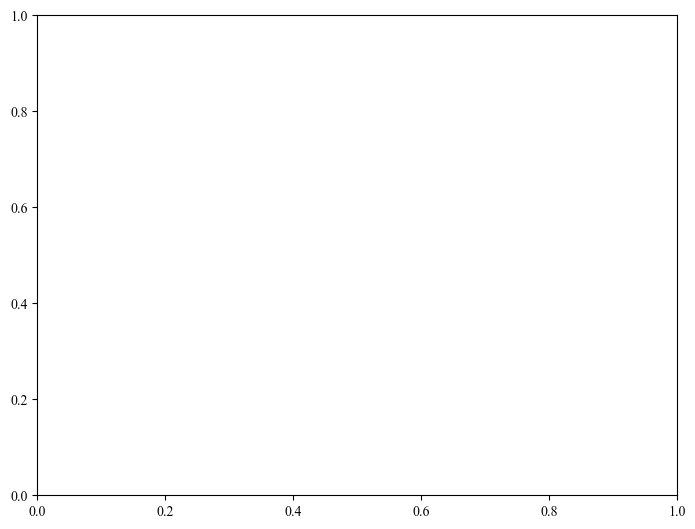

In [7]:

# for reference
begin_point = 2.5E-1

x_ref = [x[0], x[-1]]
y_ref = [begin_point, begin_point/np.sqrt(np.power(2,len(x)))]




fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])
plt.errorbar(x, mean, yerr=yerr, capsize = 3, label='Original')
# plt.errorbar(x, mean_infty, yerr=yerr_infty, capsize = 3, label='Original')

plt.errorbar(x2, mean2, yerr=yerr2, capsize = 3, label='Relaxed')
# plt.errorbar(x2, mean_infty2, yerr=yerr_infty2, capsize = 3, label='Relaxed')
plt.plot(x_ref, y_ref, linestyle='--', label='1/2 order')
plt.yscale('log')
# plt.ylim((1e-9,1))
plt.xscale('log')
plt.xlabel('$n$', size=20)
plt.ylabel('$L^2$ error', size=20)
plt.legend(fontsize=15)
# ax.set_xticks(x)
plt.xticks(x, x, fontsize=15)
plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
fig.text(X + .07, Y - 0.05, '(a)', size=20, weight='bold')



l, b, w, h = 0.115, 0.16, 0.24, 0.24
ax2=fig.add_axes([l, b, w, h])
    
plt.plot(x_test.cpu().detach().numpy(), y_test.cpu().detach().numpy(), label='Data', linewidth = 1.5, color = '#7f7f7f', zorder = 1)
plt.scatter(x_test.cpu().detach().numpy()[::8], y_pred[::8], label='n', color = '#D25565', marker=".", s = 20, zorder = 2) 


ax2.yaxis.tick_right()
plt.xlabel('$x$', fontsize=15)
ax2.yaxis.set_label_position('right')
plt.ylabel('$y$', fontsize=15)
# plt.legend(fontsize=12, loc=(0,1.1))
plt.title('$n = '+str(width)+'$', fontsize=15)
plt.xticks([-1, 1], fontsize=10)
plt.yticks([-1, 1], fontsize=10)

ax2.set_ylim(-1.2, 1.2)
ax2.set_xlim(-1.2, 1.2)

ax2.xaxis.set_label_coords(0.5, -0.1)
ax2.yaxis.set_label_coords(1.1, 0.5)


plt.savefig('plot_L2.pdf', bbox_inches='tight')
plt.show()

# plt.style.use(style_name)

In [ ]:

# for reference
begin_point = 2.5E-1

x_ref = [x[0], x[-1]]
y_ref = [begin_point, begin_point/np.sqrt(np.power(2,len(x)))]




fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])
plt.errorbar(x, np.sqrt(mean), yerr=yerr, capsize = 3, label='Original')
# plt.errorbar(x, mean_infty, yerr=yerr_infty, capsize = 3, label='Original')

plt.errorbar(x2, np.sqrt(mean2), yerr=yerr2, capsize = 3, label='Relaxed')
# plt.errorbar(x2, mean_infty2, yerr=yerr_infty2, capsize = 3, label='Relaxed')
plt.plot(x_ref, y_ref, linestyle='--', label='1/2 order')
plt.yscale('log')
# plt.ylim((1e-9,1))
plt.xscale('log')
plt.xlabel('$n$', size=20)
plt.ylabel('MSE error', size=20)
plt.legend(fontsize=15)
# ax.set_xticks(x)
plt.xticks(x, x, fontsize=15)
plt.yticks(fontsize=15)
# ax()
X = ax1.get_position().x0
Y = ax1.get_position().y1 
fig.text(X + .07, Y - 0.05, '(a)', size=20, weight='bold')



l, b, w, h = 0.115, 0.16, 0.24, 0.24
ax2=fig.add_axes([l, b, w, h])
    
plt.plot(x_test.cpu().detach().numpy(), y_test.cpu().detach().numpy(), label='Data', linewidth = 1.5, color = '#7f7f7f', zorder = 1)
plt.scatter(x_test.cpu().detach().numpy()[::8], y_pred[::8], label='n', color = '#D25565', marker=".", s = 20, zorder = 2) 


ax2.yaxis.tick_right()
plt.xlabel('$x$', fontsize=15)
ax2.yaxis.set_label_position('right')
plt.ylabel('$y$', fontsize=15)
# plt.legend(fontsize=12, loc=(0,1.1))
plt.title('$n = '+str(width)+'$', fontsize=15)
plt.xticks([-1, 1], fontsize=10)
plt.yticks([-1, 1], fontsize=10)

ax2.set_ylim(-1.2, 1.2)
ax2.set_xlim(-1.2, 1.2)

ax2.xaxis.set_label_coords(0.5, -0.1)
ax2.yaxis.set_label_coords(1.1, 0.5)


plt.savefig('plot_MSE.pdf', bbox_inches='tight')
plt.show()

# plt.style.use(style_name)